In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('../data/raw_data.csv')

df.head()

,birads,age,mass_shape,mass_margin,mass_density,cancer
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1


Null values


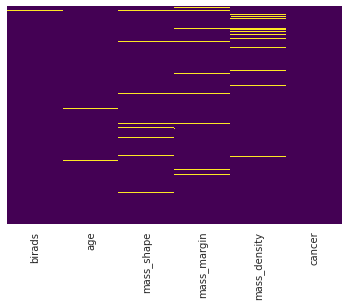

In [78]:
# Replace non numeric values for nan
df = df.apply(pd.to_numeric, errors='coerce')

print("Null values")
sns.heatmap(df.isnull(), yticklabels=False,cbar=False,cmap='viridis')


# Replace misintroduced values for nan (or drop them if they 
# are in the majority class)
# If a line has a null or misintroduced value, and it is in the
# majoritry class, we simply discard it. This way, we have
# less values to impute and balance the dataset
for index, row in df.iterrows():
    for c in df.columns:
        if (c == 'birads' and row[c] < 1 or row[c] > 5) or \
           (c == 'age' and row[c] < 8 or row[c] > 110) or \
           (c == 'mass_shape' and row[c] < 1 or row[c] > 4) or \
           (c == 'mass_margin' and row[c] < 1 or row[c] > 5) or \
           (c == 'mass_density' and row[c] < 1 or row[c] > 4):
            if df['cancer'].value_counts()[row['cancer']] > df.shape[0]/2:
                df.drop(index, axis=0, inplace=True)
                break
            else:
                row[c] = np.nan 

Null and misintroduced values


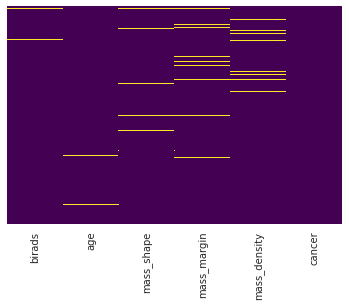

In [79]:
print("Null and misintroduced values")
sns.heatmap(df.isnull(), yticklabels=False,cbar=False,cmap='viridis')

In [80]:
# We will separate the train/test before dealing with nul values
# Because we don't want 'synthetic' values in the test dataset
test_indices = df[df['cancer']==1].dropna().sample(40).index
test_indices = np.concatenate([test_indices, df[df['cancer']== 0].dropna().sample(40).index])
test = df.filter(test_indices, axis=0)
train = df.drop(test_indices, axis=0)

print("Test dataset:")
print(test['cancer'].value_counts())
print("Train dataset:")
print(train['cancer'].value_counts())

Test dataset:
1    40
0    40
Name: cancer, dtype: int64
Train dataset:
1    405
0    405
Name: cancer, dtype: int64


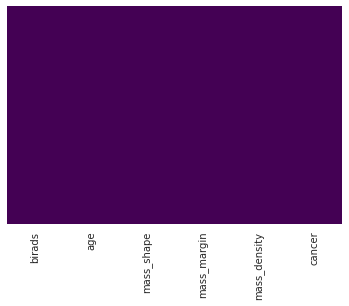

In [81]:
# Let's make sure there are no null values in the test dataset
sns.heatmap(test.isnull(), yticklabels=False,cbar=False,cmap='viridis')

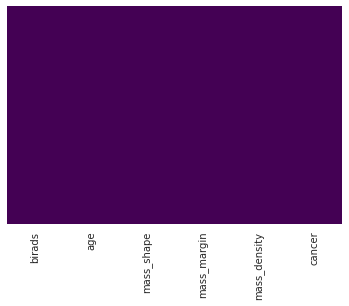

In [82]:
from sklearn.impute import KNNImputer

# We will use KNearestNeighbours to impute the missing values in our train dataset
imputer = KNNImputer(n_neighbors=500, weights="uniform")
train = pd.DataFrame(imputer.fit_transform(train.values), columns = train.columns)

sns.heatmap(train.isnull(), yticklabels=False,cbar=False,cmap='viridis')

In [83]:
# Now that we have dealt with the null and misintroduced values,
# we can drop the BI-RADS column since we won't be using it
# (even though it was useful to impute missing data)
train.drop('birads', axis=1, inplace=True)
test.drop('birads', axis=1, inplace=True)

# Data is already balanced because of the rows we discarded when
# we searched for misintroduced values
# So all we have left to do is normalize data (so it is better
# fit for use in neural networks)
from  sklearn.preprocessing import MinMaxScaler

ms = MinMaxScaler()
train = pd.DataFrame(ms.fit_transform(train.values), columns=train.columns)

ms = MinMaxScaler()
test = pd.DataFrame(ms.fit_transform(test.values), columns=test.columns)

train.head()


,age,mass_shape,mass_margin,mass_density,cancer
0,0.628205,0.666667,1.0,0.666667,1.0
1,0.320513,0.000000,0.0,0.639333,1.0
2,0.512821,1.000000,1.0,0.666667,1.0
3,0.717949,0.000000,1.0,0.648667,1.0
4,0.500000,0.000000,1.0,0.666667,1.0


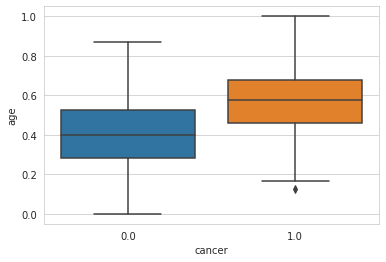

In [84]:
# Now let's take a closer at each feature individualy to see if
# there's anything else we should deal with
sns.boxplot(x='cancer', y='age', data=train)

As we could have guessed, patients that effectively have cancer tend to be older.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f87dc5d58d0>,
      dtype=object)

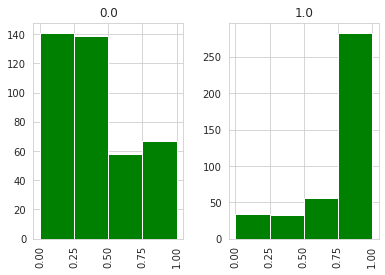

In [85]:
train['mass_shape'].hist(train['cancer'], color='green',bins=4)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f87dc7c2940>,
      dtype=object)

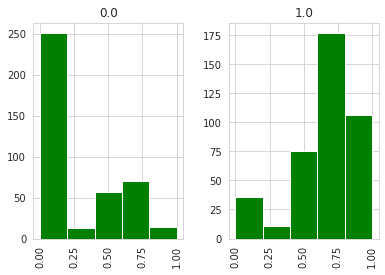

In [86]:
train['mass_margin'].hist(train['cancer'], color='green',bins=5)

Both mass shape and mass margin are features that seem to show a completely different distribution in cancer vs no-cancer cases.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f87dc466390>,
      dtype=object)

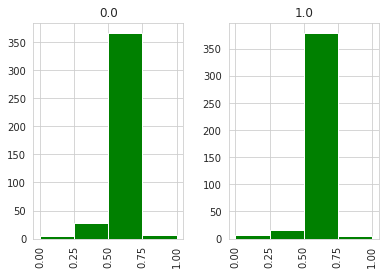

In [87]:
train['mass_density'].hist(train['cancer'], color='green',bins=4)

Probably mass density isn't going to be much of a strong factor in the prediction.

In [88]:
# Everything seems to be fine
# Finally, we just write both dataset into csv files 
train.to_csv("../data/train.csv", index=False)
test.to_csv("../data/test.csv", index=False)